In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography

# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)

import KSEMhd
from importlib import reload  
KSEMhd = reload(KSEMhd)
from KSEMhd import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
# provider.backends()

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
# print(provider.backends())
name = "ibm_hanoi"
backend = provider.get_backend(name)
print(backend.properties().to_dict()[ 'last_update_date'])
backend_noise_model = NoiseModel.from_backend(backend)
# backend =  AerSimulator.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix')
den_simu_noise = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

2022-11-17 08:22:55-05:00


/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (248486.40446034473 > 2 * 104611.66931085872). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (232360.31808010972 > 2 * 97355.2679531514). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (207782.54392148953 > 

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067074 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.067187 > 1.066667). Truncating to maximum value.
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (160336.2964006462 > 2 * 79166.67863253632). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.80000

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9922, 0.0078], [0.010199999999999987, 0.9898]],
 'gate_qubits': [(26,)]}

In [5]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [6]:
from qiskit import Aer
def single_iter(n_qubits=3):
    iterate = QuantumCircuit(n_qubits)
    iterate.ry(np.pi,0)
    iterate.ry(np.pi,1)
    iterate.cx(0,1)
    iterate.ry(np.pi,0)
    iterate.ry(np.pi,1)
    iterate.barrier()
    iterate.ry(np.pi,1)
    iterate.ry(np.pi,2)
    iterate.cx(1,2)
    iterate.ry(np.pi,1)
    iterate.ry(np.pi,2)
    iterate.barrier()
    return iterate
# def single_iter(n_qubits=2):
#     iterate = QuantumCircuit(n_qubits)
#     iterate.h(0)
#     iterate.cx(0,1)
#     iterate.cx(1,2)
#     iterate.barrier()
#     iterate.cx(1,2)
#     iterate.cx(0,1)
#     iterate.h(0)
#     iterate.barrier()
#     return iterate

def iterative_circ(num_itrs, n_qubits=3, save_den = True, meas_basis='z'):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if meas_basis == 'x':
        for i in range(n_qubits):
            total_circ.h(i)
    if meas_basis == 'y':
        for i in range(n_qubits):
            total_circ.sdg(i)
            total_circ.h(i)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

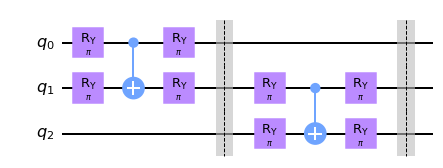

In [7]:
single_iter(n_qubits).draw("mpl")

10


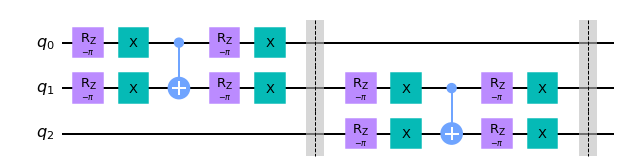

In [8]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu_noise)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [9]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 0.0001893559093040918 sec
T2: 0.000305469454459999 sec
Circuit Operation Time: 8e-06 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [10]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [11]:
total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu_noise.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu_noise.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEMhd.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9818025813361291
0.9620873697829619
0.9488592065820719
0.925777696699207
0.9091338671055245
0.8910839536629058
0.879031842270624
0.857856566202623
0.8426325168454052
0.8261055208560287

Prob Vec
[1.31072998e-02 7.62939453e-05 9.65728760e-01 8.02612305e-03
 1.67846680e-03 1.19018555e-03 1.00708008e-02 1.22070312e-04]
[1.38092041e-02 1.03759766e-03 4.24194336e-03 4.13513184e-03
 9.52270508e-01 6.77490234e-03 1.75323486e-02 1.98364258e-04]
[0.00544739 0.00404358 0.01502991 0.00411987 0.01617432 0.00135803
 0.94586182 0.00796509]
[0.9357605  0.00880432 0.02069092 0.0045166  0.01391602 0.00416565
 0.00793457 0.00421143]
[0.01979065 0.00421143 0.93034363 0.01156616 0.00880432 0.00527954
 0.01585388 0.00415039]
[0.01980591 0.00613403 0.01211548 0.00843811 0.91305542 0.01072693
 0.02497864 0.00474548]
[0.01254272 0.00791931 0.02172852 0.00837708 0.02388    0.0050354
 0.90940857 0.0111084 ]
[0.90156555 0.01280212 0.0269165  0.00827026 0.01976013 0.00761414
 0.01449585 0.00857544]
[0.02

In [12]:
def meas_mat(num_qubits):# H, measurement matrix for vectorized density matrix
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = csc_matrix((nrows, ncols), dtype=complex)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1 # take out the diagonal terms in vectorized density matrix
    return mat

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [19]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum valu

In [20]:
tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu_for_tomo, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.9242082398645697
0.8576332534419603
0.8071964525642982
0.7665983996850984
0.734400404289669
0.6827976202210091
0.6368548075358075
0.6063451961275694
0.5654601344355826
0.545939928219643

Tomography Prob Vec
[0.00776281 0.00252323 0.95961313 0.0085591  0.00757314 0.00371643
 0.00609238 0.00415979]
[0.0094086  0.00500061 0.01815451 0.0082471  0.92474976 0.01189813
 0.01677935 0.00576194]
[0.02154253 0.00962238 0.01231006 0.01071053 0.0240913  0.00846517
 0.89616421 0.01709381]
[0.87251576 0.01613251 0.03300885 0.01103044 0.01032083 0.0137417
 0.0317129  0.01153702]
[0.02700288 0.017247   0.85216686 0.0199458  0.04123615 0.0111971
 0.01925744 0.01194677]
[0.01363376 0.01807176 0.0467252  0.021287   0.81918591 0.02431444
 0.04414236 0.01263957]
[0.05395508 0.02514648 0.02368164 0.01765951 0.04890951 0.01717122
 0.79109701 0.02237956]
[0.77001274 0.02291613 0.05952289 0.02113719 0.0236731  0.02083725
 0.06017859 0.02172211]
[0.06580946 0.02403429 0.74169922 0.02967665 0.

## Kalman Smoother

In [13]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

## Add X,Y-basis measurements

In [14]:
total_simu_probs_x = [] # measurement result, x-basis
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False, meas_basis = 'x'), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu_noise.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs_x.append(KSEMhd.dictToVec(iter_res.get_counts()))

In [15]:
total_simu_probs_y = [] # measurement result, x-basis
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False, meas_basis = 'y'), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu_noise.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs_y.append(KSEMhd.dictToVec(iter_res.get_counts()))

In [16]:
observs = []
for i in range(len(total_simu_probs)):
    z_meas_p = total_simu_probs[i]
    x_meas_p = total_simu_probs_x[i]
#     y_meas_p = total_simu_probs_y[i]
#     observs.append(np.append(np.append(z_meas_p, x_meas_p),y_meas_p))
    observs.append(np.append(z_meas_p, x_meas_p))
observs

[array([1.31072998e-02, 7.62939453e-05, 9.65728760e-01, 8.02612305e-03,
        1.67846680e-03, 1.19018555e-03, 1.00708008e-02, 1.22070312e-04,
        1.23947144e-01, 1.25717163e-01, 1.25747681e-01, 1.26647949e-01,
        1.24084473e-01, 1.24359131e-01, 1.25656128e-01, 1.23840332e-01]),
 array([1.38092041e-02, 1.03759766e-03, 4.24194336e-03, 4.13513184e-03,
        9.52270508e-01, 6.77490234e-03, 1.75323486e-02, 1.98364258e-04,
        1.26800537e-01, 1.25717163e-01, 1.27655029e-01, 1.24099731e-01,
        1.25366211e-01, 1.23565674e-01, 1.23764038e-01, 1.23031616e-01]),
 array([0.00544739, 0.00404358, 0.01502991, 0.00411987, 0.01617432,
        0.00135803, 0.94586182, 0.00796509, 0.12651062, 0.12553406,
        0.12435913, 0.12409973, 0.12277222, 0.12504578, 0.12574768,
        0.12593079]),
 array([0.9357605 , 0.00880432, 0.02069092, 0.0045166 , 0.01391602,
        0.00416565, 0.00793457, 0.00421143, 0.1242981 , 0.12606812,
        0.1268158 , 0.12428284, 0.12442017, 0.12527466, 0.

### Initialize

In [23]:
initial_state = np.array([0]*((2**3)**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [24]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = observs[0].size

# M = np.identity(num_dim_state, dtype=complex)* 0.02 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
# Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
# R = np.identity(num_dim_obs, dtype=complex)* 0.1 * (1) # meas covariance
# P = np.identity(num_dim_state, dtype=complex)* 0.05 * (1)# 
M = np.identity(num_dim_state, dtype=complex)* 0.4 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 1 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.01 * (1)# 

In [25]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 16, 4096)

### EM and Smoother - Total

Use longest iterations

In [26]:
def norm_diag(mat):
    her_mat = mat.copy()
    diags = her_mat.diagonal()
    diagsum = diags.sum()
    diags_normed = diags/diagsum
    try: 
        np.fill_diagonal(her_mat, diags_normed)
    except:
        her_mat.setdiag(diags_normed)
    return her_mat

In [27]:
total_smoother_dens = []
total_smoother_purs = []

# observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
realX0 = KSEMhd.closed_den_mat(realX0) # find closest valid density matrix
realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEMhd.closed_den_mat(x_est)
#     final_den = norm_diag(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


ValueError: inconsistent shapes

In [61]:
np.linalg.norm(unitaries[0]-realF)

0.0

In [62]:
print(np.sum(realQ.real<0))

2096


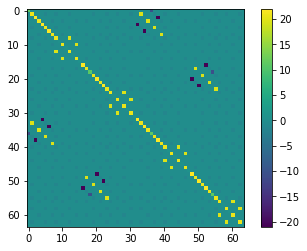

In [63]:
plt.imshow(realQ.real)
plt.colorbar()
plt.show()

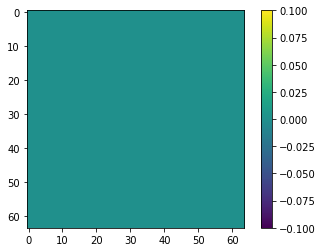

In [64]:
plt.imshow(realQ.imag)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [65]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [66]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [67]:
total_smoother_dens[0].diagonal().flatten()

matrix([[0.00955214+0.j, 0.94289381+0.j, 0.00615117+0.j, 0.00159828+0.j,
         0.01160088+0.j, 0.01169699+0.j, 0.01270167+0.j, 0.00380507+0.j]])

In [68]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

array([[0.00955214+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.94289381+0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.00615117+0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.00159828+0.j,
        0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.01160088+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.01169699+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
        0.        +0.j, 0.        +0.j, 0.01270167+0.j, 0.

In [69]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))
#     print(total_smoother_dens[8])
#     print(total_simu_dens[8].data)

0.16426969680933068
0.7053986556280903
0.6437051926007064
0.0076821221550614745
0.056673347698407456
0.5649869524053681
0.18823087613763675
0.012415143963505635
0.08783609773141257
0.2629216212174431


In [70]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.9166121135213103
0.8793320654296413
0.8317096481692046
0.8047904216077375
0.7672906495135456
0.7349452125881168
0.6987577752084017
0.6809231474325571
0.652457563747712
0.627035393605906


## Check the fidelity between estimated state and the real state in the simulator

In [79]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

def prob_dist(p,q):
    return np.abs(p-q).sum()*0.5

In [88]:
len(total_simu_dens), max_num_itrs

(10, 10)

In [91]:
realX0.shape

(64,)

In [105]:
np.matrix(unitary)

matrix([[-0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  1.+0.j,
          0.+0.j],
        [ 0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j,
         -0.+0.j],
        [-1.+0.j, -0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
          0.+0.j],
        [ 0.+0.j, -0.+0.j, -0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,
          0.+0.j],
        [ 0.+0.j, -0.+0.j,  1.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,  0.+0.j,
          0.+0.j],
        [ 0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,
          0.+0.j],
        [ 0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j,  0.+0.j,
          0.+0.j],
        [-0.+0.j,  0.+0.j,  0.+0.j, -0.+0.j,  0.+0.j, -0.+0.j, -0.+0.j,
          1.+0.j]])

In [108]:
v = np.zeros(2**3, dtype=float)
v[0] = 1


res_den = unitaries[0].dot(unitaries[0].dot(realX0))
np.matrix(unitary).dot(np.matrix(unitary).dot(v).reshape((8,1))), np.diag(np.matrix(res_den).flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F')).real

(matrix([[ 0.+0.j],
         [-0.+0.j],
         [-0.+0.j],
         [ 0.+0.j],
         [-1.+0.j],
         [ 0.+0.j],
         [ 0.+0.j],
         [-0.+0.j]]),
 array([0.00005618, 0.00000072, 0.00114783, 0.00010748, 0.99733985,
        0.00068913, 0.00042093, 0.00023787]))


[0.00100638 0.00001163 0.97947045 0.00669124 0.00567025 0.00469152
 0.00242725 0.00003128]
[0.00955214 0.94289381 0.00615117 0.00159828 0.01160088 0.01169699
 0.01270167 0.00380507]
[0.00776281 0.00252323 0.95961313 0.0085591  0.00757314 0.00371643
 0.00609238 0.00415979]
Iteration 1 KS Fid: 0.9784122376885802 Tomo Fid: 0.020832411156785573

[0.00340687 0.00464337 0.00917964 0.01121711 0.95615355 0.00658506
 0.00864662 0.00016777]
[0.00919148 0.00623169 0.00517959 0.10432534 0.57913956 0.0845724
 0.15962091 0.05173904]
[0.0094086  0.00500061 0.01815451 0.0082471  0.92474976 0.01189813
 0.01677935 0.00576194]
Iteration 2 KS Fid: 0.38101405307014247 Tomo Fid: 0.03437379738044298

[0.01388505 0.01098574 0.00449051 0.01115557 0.01004637 0.00471654
 0.93801016 0.00671007]
[0.00947772 0.01411347 0.31757613 0.00983175 0.55914547 0.02140629
 0.05250658 0.0159426 ]
[0.02154253 0.00962238 0.01231006 0.01071053 0.0240913  0.00846517
 0.89616421 0.01709381]
Iteration 3 KS Fid: 0.8912347301671 Tom

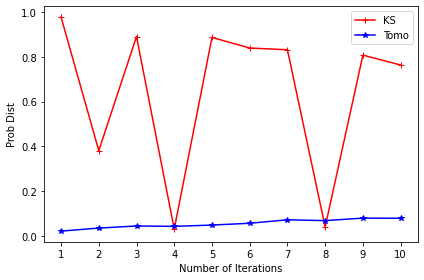

In [109]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
np.set_printoptions(suppress=True)
diff_prob_all= []
diff_prob_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    prob_difference_tomo =  prob_dist(total_simu_dens[i].probabilities(), qis_den_tomo.probabilities())
    prob_difference_all =  prob_dist(total_simu_dens[i].probabilities(), qis_den_all.probabilities())
    diff_prob_all.append(prob_difference_all)
    diff_prob_tomo.append(prob_difference_tomo)
    print()
    print(total_simu_dens[i].probabilities())
    print( qis_den_all.probabilities())
    print(qis_den_tomo.probabilities())
    
    print("Iteration",i+1, "KS Fid:", prob_difference_all, "Tomo Fid:", prob_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_prob_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_prob_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Prob Dist")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

In [74]:
 qis_den_all.probabilities()

array([0.02839488, 0.02758082, 0.04926836, 0.02205817, 0.04656534,
       0.04834989, 0.73992391, 0.03785863])

Iteration 1 KS Fid: 0.011104253220388374 Tomo Fid: 0.9767335572943865
Iteration 2 KS Fid: 0.6323721972931486 Tomo Fid: 0.9705051039277524
Iteration 3 KS Fid: 0.11581053553175033 Tomo Fid: 0.962339107021715
Iteration 4 KS Fid: 0.9933400359952066 Tomo Fid: 0.9595037023664446
Iteration 5 KS Fid: 0.09938161959916894 Tomo Fid: 0.9463721307777148
Iteration 6 KS Fid: 0.16082366556478306 Tomo Fid: 0.9441483520331874
Iteration 7 KS Fid: 0.1593625716842812 Tomo Fid: 0.9618775901610772
Iteration 8 KS Fid: 0.9904257754725737 Tomo Fid: 0.9549654737884307
Iteration 9 KS Fid: 0.19097111518120694 Tomo Fid: 0.9712288289643626
Iteration 10 KS Fid: 0.27251916369313633 Tomo Fid: 0.9539027542686669


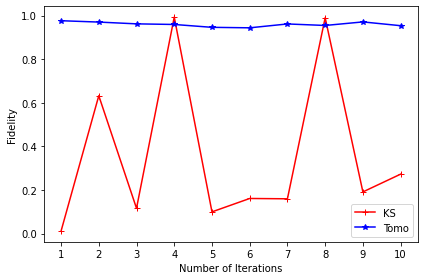

In [72]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

In [ ]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

In [ ]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

In [ ]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

In [ ]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()